In [1]:
import random
import os
import torch
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import lognorm
import numpy as np
import logging
import sys
from sdo.datasets.sdo_dataset import SDO_Dataset
from torch.utils.data import DataLoader

notebook_name = '03_MJ_Baseline_for_AutoCal-Experiment2'

np.set_printoptions(precision=3)    

## Loading the data

In [2]:
#just a way to get nice logging messages from the sdo package
logformat = "[%(asctime)s] %(levelname)s:%(name)s:%(message)s"
#logging.basicConfig(level=logging.DEBUG, stream=sys.stdout, format=logformat, datefmt="%Y-%m-%d %H:%M:%S")
logging.basicConfig(level=logging.WARNING, stream=sys.stdout, format=logformat, datefmt="%Y-%m-%d %H:%M:%S")

In [3]:
subsample = 1
original_ratio = 512
img_shape = int(original_ratio/subsample)
instr = ['AIA','AIA','AIA','AIA','AIA','AIA','AIA','HMI'] #RED FLAG: Insert HMI as the first instrument in the 'instr'.
channels = ['0094','0131','0171','0193','0211','0304','0335','bz']#RED FLAG: Insert HMI as the first channel in the 'channels'.


In [4]:
##Loading datasets with the latest SDO_Datset
#data = SDO_Dataset(instr=instr, channels=channels, yr_range=[2012, 2013], #experiment 1
#data = SDO_Dataset(instr=instr, channels=channels, yr_range=[2010, 2011], #experiment 2
data = SDO_Dataset(instr=instr, channels=channels, yr_range=[2015, 2016], #experiment 2
                         mnt_step=1, day_step=1, h_step=6, min_step=60,
                         subsample=subsample, 
                         normalization=0, scaling=False, test=True)
batch_size = data.__len__()*len(channels) # Loading the number of images = files*channels
loader= DataLoader(data,batch_size=batch_size, shuffle=False) 

In [5]:
#The loop below is used to load the data from the data loader.
for batch_idx, (input_data) in enumerate(loader):
    input_data = input_data.numpy()

## Reference

In [6]:
# N.B- we do not deal with the noise in the channels 94, 335. or any other AIA channel. Important for the paper. 

dimension_input_data = input_data.shape
xposmin=np.int(original_ratio/(4*subsample))
xposmax=np.int(original_ratio/(4*subsample)) + np.int(original_ratio/(2.*subsample))
yposmin=np.int(original_ratio/(4*subsample))
yposmax=np.int(original_ratio/(4*subsample)) + np.int(original_ratio/(2.*subsample))
roi_cut_out=[xposmin,xposmax,yposmin,yposmax] # Avoiding the limb of the Sun.

mag_threshold = 5. # This is the magnetic field strength in Gauss, above which we mask all the pixels with 0 value, rest are 1.

#compute the most probable value for the first image (ground truth) once and iterate over the dimmed. 
mask_qs_reference=np.zeros((np.int(original_ratio/(2.*subsample)),np.int(original_ratio/(2.*subsample))),dtype=float)
input_cut_out_reference=input_data[0,:,roi_cut_out[0]:roi_cut_out[1],roi_cut_out[2]:roi_cut_out[3]] #Index =0 i.e. time=0
indices_threshold_reference =np.where(np.abs(input_cut_out_reference[7,:,:]) <= mag_threshold)
mask_qs_reference[indices_threshold_reference[0],indices_threshold_reference[1]]=1 # Setting the pixels for the QS to 1

mode_ref = np.zeros([7])
peak_ref=np.zeros([7])

for ch in range(len(channels)-1): #For each time, iterate over the AIA channels. The last channel is HMI so len(channels)-1.
    quiet_sun_AIA_reference = mask_qs_reference*input_cut_out_reference[ch,:,:]#.copy #MJ
    indices_no_zero = np.where(quiet_sun_AIA_reference>=0.1) #Considering the pixels without the zeros.
    shape_ref,loc_ref,scale_ref = lognorm.fit(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]],floc=0)# Fitting a log normal distribution 
    mode_ref[ch] = np.exp(np.log(scale_ref)-shape_ref**2)+loc_ref

    test_histo=np.histogram(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]], bins=3000)
    peak_ref[ch]=test_histo[1][np.argmax(test_histo[0])]
    

print("Mode of the fit", mode_ref)
print("Peak of the fit", peak_ref)

Mode of the fit [  1.866  10.305 253.792 356.251 136.853 171.421   9.983]
Peak of the fit [  1.572   8.054 220.065 484.433 113.934 156.278   9.87 ]


0
1
2
3
4
5
6


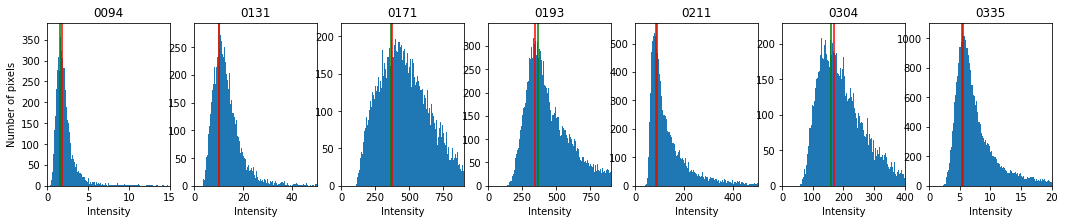

In [8]:
#NO NEED TO RUN
#Just plotting the distributions to check that everything is ok

import pandas as pd
#xlimit_plot = [20,50,900,900,500,400,80] #this can be changed for the visualization
xlimit_plot = [15,50,900,900,500,400,20] #this can be changed for the visualization

fig, ax = plt.subplots(1, 7, figsize=(18,3), sharey=False)

for ch in range(len(channels)-1): 
    print(ch)
    quiet_sun_AIA_reference = mask_qs_reference*input_cut_out_reference[ch,:,:]#.copy #MJ
    indices_no_zero = np.where(quiet_sun_AIA_reference>=0.1) #Considering the pixels without the zeros.
    ax[0].set_ylabel('Number of pixels');
    ax[ch].set_title(channels[ch])
    ax[ch].set_xlabel('Intensity')
    ax[ch].set_xlim([0,xlimit_plot[ch]])
    ax[ch].hist(x=pd.Series(np.ravel(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]])), bins=3000)  
    ax[ch].axvline(x=mode_ref[ch], color='green')
    ax[ch].axvline(x=peak_ref[ch], color='red')


diff with mode = [0.026 0.043 0.028 0.013 0.057 0.006 0.03 ]
diff with peak = [0.115 0.136 0.042 0.031 0.177 0.023 0.125]
diff with mode = [0.072 0.003 0.061 0.076 0.031 0.001 0.002]
diff with peak = [0.007 0.018 0.108 0.123 0.108 0.015 0.012]
diff with mode = [0.043 0.001 0.058 0.088 0.024 0.005 0.019]
diff with peak = [0.028 0.02  0.211 0.219 0.188 0.034 0.019]
diff with mode = [0.02  0.003 0.12  0.012 0.038 0.015 0.154]
diff with peak = [0.054 0.005 0.419 0.02  0.158 0.06  0.204]
diff with mode = [0.002 0.008 0.099 0.011 0.089 0.02  0.097]
diff with peak = [0.107 0.069 0.318 0.049 0.106 0.097 0.069]


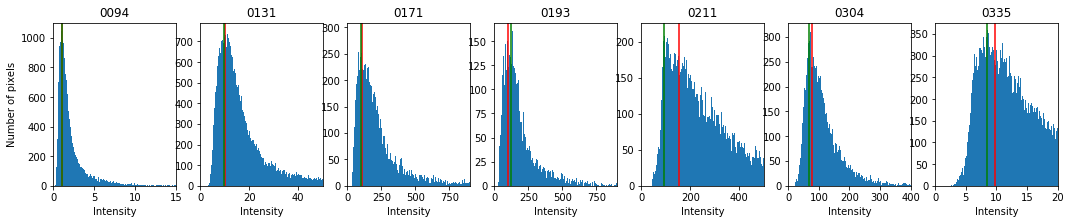

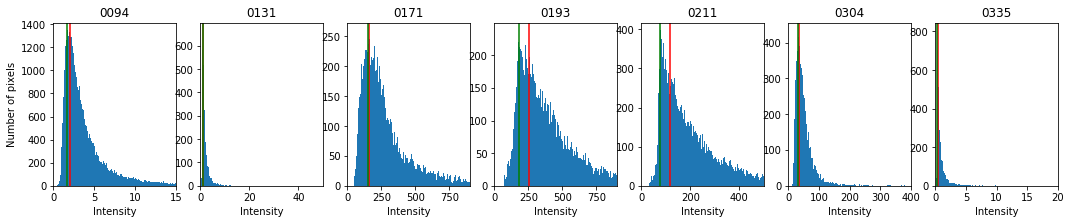

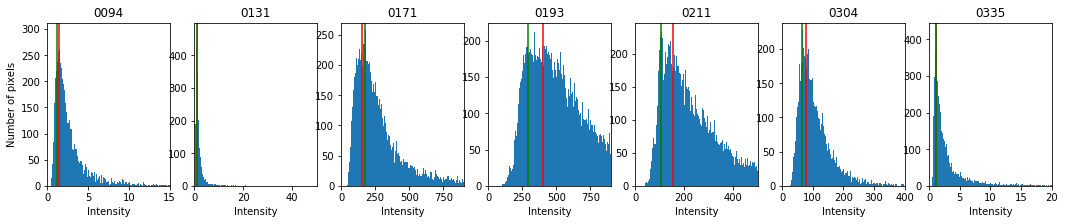

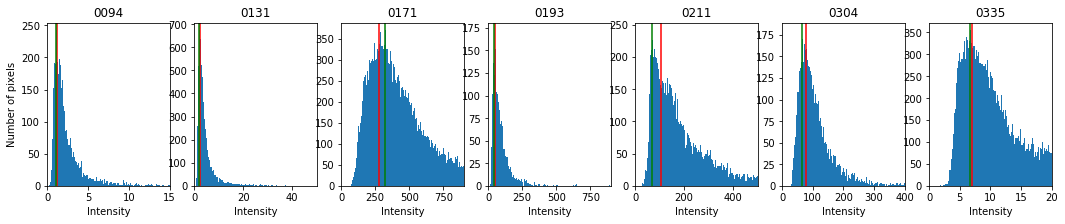

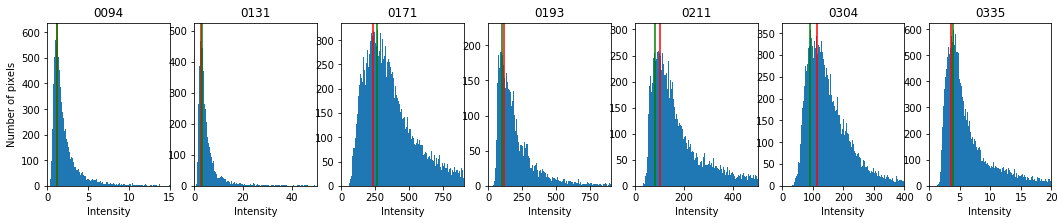

In [15]:
#NO NEED TO RUN
#Checking the results for 10 images and getting some histograms to see whether everything is working fine.


xlimit_plot = [15,50,900,900,500,400,20] #this can be changed for the visualization

alpha_gt = np.zeros([dimension_input_data[0]-1,7])
alpha_pred = np.zeros([dimension_input_data[0]-1,7])
alpha_pred_peak = np.zeros([dimension_input_data[0]-1,7])

mode_dim=np.zeros([7])
peak_dim=np.zeros([7])

nsteps = float(data.__len__())
min_alpha = 0.01
empty_img  = 0

#for index in range(0,dimension_input_data[0]-1): # Iterating over the images throughout the dataset
for index in range(5): # Iterating over the images throughout the dataset
    mask_qs=np.zeros((np.int(original_ratio/(2.*subsample)),np.int(original_ratio/(2.*subsample))),dtype=float) #This is the mask for the quiet sun. 
    input_cut_out=input_data[index+1,:,roi_cut_out[0]:roi_cut_out[1],roi_cut_out[2]:roi_cut_out[3]]
    indices_threshold =np.where(np.abs(input_cut_out[7,:,:]) <= mag_threshold)
    mask_qs[indices_threshold[0],indices_threshold[1]]=1 # Setting the pixels for the QS to 1
    
    # This is our alpha ground truth.The while loop below ensures that we do not have any value less than min_alpha.
    dim_factor = np.zeros(7)
    while any(dim_factor < min_alpha):
       dim_factor = np.random.rand(7)
    alpha_gt[index,:] = dim_factor

    fig, ax = plt.subplots(1, 7, figsize=(18,3), sharey=False)

    for ch in range(len(channels)-1): #For each time, iterate over the AIA channels. The last channel is HMI so len(channels)-1.        
        # The same process but now for the artificially dimmed image.
        dim_input_data = dim_factor[ch]*input_cut_out[ch,:,:]
        intensity_mask = dim_input_data*mask_qs>=0.1 
        
        if (intensity_mask).any():
            indices_no_zero_dim = np.where(intensity_mask)
            shape_dim,loc_dim,scale_dim = lognorm.fit(dim_input_data[indices_no_zero_dim[0],indices_no_zero_dim[1]],floc=0)
            mode_dim[ch] = np.exp(np.log(scale_dim)-shape_dim**2)+loc_dim
            test_histo=np.histogram(dim_input_data[indices_no_zero_dim[0],indices_no_zero_dim[1]], bins=3000)
            peak_dim[ch]=test_histo[1][np.argmax(test_histo[0])]
        
            # Now compute the alpha_predicted
            dim_factor_pred       = mode_dim[ch]/mode_ref[ch]
            alpha_pred[index,ch]  = dim_factor_pred    
            dim_factor_pred_peak  = peak_dim[ch]/peak_ref[ch]
            alpha_pred_peak[index,ch]   = dim_factor_pred_peak
            

        else:
            empty_img +=1
            # discarded images are eliminated from the mean
            alpha_pred[index,ch] = np.nan
            alpha_pred_peak[ch]  = np.nan

        ax[0].set_ylabel('Number of pixels');
        ax[ch].set_title(channels[ch])
        ax[ch].set_xlabel('Intensity')
        ax[ch].set_xlim([0,xlimit_plot[ch]])
        ax[ch].hist(x=pd.Series(np.ravel(dim_input_data[indices_no_zero_dim[0],indices_no_zero_dim[1]])), bins=3000)
        ax[ch].axvline(x=mode_dim[ch], color='red')
        ax[ch].axvline(x=peak_dim[ch], color='green')

    print('diff with mode =',np.abs(alpha_pred[index]-alpha_gt[index]))
    print('diff with peak =',np.abs(alpha_pred_peak[index]-alpha_gt[index]))

In [7]:
#Running the previous cell without the histograms, for all the batch.

alpha_gt = np.zeros([dimension_input_data[0]-1,7])
alpha_pred = np.zeros([dimension_input_data[0]-1,7])
alpha_pred_peak = np.zeros([dimension_input_data[0]-1,7])

mode_dim=np.zeros([7])
peak_dim=np.zeros([7])
primary_metric_ch=np.zeros([7])

nsteps = float(data.__len__())
min_alpha = 0.01
tol = 0.1
empty_img  = 0

for index in range(0,dimension_input_data[0]-1): # Iterating over the images throughout the dataset
    mask_qs=np.zeros((np.int(original_ratio/(2.*subsample)),np.int(original_ratio/(2.*subsample))),dtype=float) #This is the mask for the quiet sun. 
    input_cut_out=input_data[index+1,:,roi_cut_out[0]:roi_cut_out[1],roi_cut_out[2]:roi_cut_out[3]]
    indices_threshold =np.where(np.abs(input_cut_out[7,:,:]) <= mag_threshold)
    mask_qs[indices_threshold[0],indices_threshold[1]]=1 # Setting the pixels for the QS to 1
    
    # This is our alpha ground truth.The while loop below ensures that we do not have any value less than min_alpha.
    dim_factor = np.zeros(7)
    while any(dim_factor < min_alpha):
       dim_factor = np.random.rand(7)
    alpha_gt[index,:] = dim_factor

    for ch in range(len(channels)-1): #For each time, iterate over the AIA channels. The last channel is HMI so len(channels)-1.        
        # The same process but now for the artificially dimmed image.
        dim_input_data = dim_factor[ch]*input_cut_out[ch,:,:]
        intensity_mask = dim_input_data*mask_qs>=0.1  #We set this to a low level as 
                                                #some distributions (especially channel 94) have very low pix. intensities
        
        if (intensity_mask).any():
            indices_no_zero_dim = np.where(intensity_mask)
            shape_dim,loc_dim,scale_dim = lognorm.fit(dim_input_data[indices_no_zero_dim[0],indices_no_zero_dim[1]],floc=0)
            mode_dim[ch] = np.exp(np.log(scale_dim)-shape_dim**2)+loc_dim
            test_histo=np.histogram(dim_input_data[indices_no_zero_dim[0],indices_no_zero_dim[1]], bins=3000)
            peak_dim[ch]=test_histo[1][np.argmax(test_histo[0])]
        
            # Now compute the alpha_predicted
            dim_factor_pred = mode_dim[ch]/mode_ref[ch]
            alpha_pred[index,ch] = dim_factor_pred    
            dim_factor_pred_peak  = peak_dim[ch]/peak_ref[ch]
            alpha_pred_peak[index,ch]   = dim_factor_pred_peak
 

        else:
            empty_img +=1
            # discarded images are eliminated from the mean
            alpha_pred[index,ch] = np.nan
            alpha_pred_peak[ch]  = np.nan


#     if (index % 10 == 0 and index !=0):
#         print(index)
#         alpha_pred_so_far = alpha_pred[0:index,:]
#         alpha_gt_so_far = alpha_gt[0:index,:]
#         not_null_pred_alpha = alpha_pred_so_far[~np.isnan(alpha_pred_so_far).any(axis=1)]
#         not_null_alpha_gt = alpha_gt_so_far[~np.isnan(alpha_pred_so_far).any(axis=1)]
#         diff  = np.abs(not_null_pred_alpha - not_null_alpha_gt)
#         primary_metric = (diff <= tol).sum() / (diff.shape[0]*diff.shape[1])
#         for ch in range(len(channels)-1):
#             print(ch)
#             primary_metric_ch = (diff[:,ch] <= tol).sum() / (diff.shape[0])
#             print("Mean primary metric so far per channel", primary_metric_ch)
        
#         print("% Progress:", index/nsteps*100)
#         print("Mean primary metric so far", primary_metric)
#         print("Discarded images", empty_img)
        

print('')
print('')
print('Final results over the whole batch')
print('')
print('')

not_null_pred_alpha      = alpha_pred[~np.isnan(alpha_pred).any(axis=1)]
not_null_pred_alpha_peak = alpha_pred_peak[~np.isnan(alpha_pred_peak).any(axis=1)]
not_null_alpha_gt        = alpha_gt[~np.isnan(alpha_pred).any(axis=1)]
not_null_alpha_gt_peak   = alpha_gt[~np.isnan(alpha_pred_peak).any(axis=1)]
diff  = np.abs(not_null_pred_alpha - not_null_alpha_gt)
diff_peak  = np.abs(not_null_pred_alpha_peak - not_null_alpha_gt_peak)
primary_metric = (diff <= tol).sum() / (diff.shape[0]*diff.shape[1])
primary_metric_peak = (diff_peak <= tol).sum() / (diff.shape[0]*diff.shape[1])
for ch in range(len(channels)-1):
    print(ch)
    primary_metric_ch = (diff[:,ch] <= tol).sum() / (diff.shape[0])
    primary_metric_ch_peak = (diff_peak[:,ch] <= tol).sum() / (diff.shape[0])
    print("Mean primary metric per channel, using mode:", primary_metric_ch)        
    print("Mean primary metric per channel, using peak:", primary_metric_ch_peak)        
print()
print("Mean primary metric over all channels, using mode:", primary_metric*100)
print("Mean primary metric over all channels, using peak:", primary_metric_peak*100)
print()
print("Discarded images", empty_img)

print()

np.set_printoptions(precision=3)    
#For Notebook output:
print('Mode')
for ch in range(len(channels)-1):
    primary_metric_ch = (diff[:,ch] <= tol).sum() / (diff.shape[0])*100
    print(primary_metric_ch)        
print()
#For Notebook output:
print('Peak')
for ch in range(len(channels)-1):
    primary_metric_ch_peak = (diff_peak[:,ch] <= tol).sum() / (diff.shape[0])*100
    print(primary_metric_ch_peak)        




Final results over the whole batch


0
Mean primary metric per channel, using mode: 0.8450292397660819
Mean primary metric per channel, using peak: 0.4152046783625731
1
Mean primary metric per channel, using mode: 0.9385964912280702
Mean primary metric per channel, using peak: 0.5029239766081871
2
Mean primary metric per channel, using mode: 0.5409356725146199
Mean primary metric per channel, using peak: 0.27485380116959063
3
Mean primary metric per channel, using mode: 0.6023391812865497
Mean primary metric per channel, using peak: 0.5263157894736842
4
Mean primary metric per channel, using mode: 0.3654970760233918
Mean primary metric per channel, using peak: 0.5175438596491229
5
Mean primary metric per channel, using mode: 0.9269005847953217
Mean primary metric per channel, using peak: 0.8508771929824561
6
Mean primary metric per channel, using mode: 0.6812865497076024
Mean primary metric per channel, using peak: 0.8157894736842105

Mean primary metric over all channels, using mode

In [ ]:
#Note: this cell is note used. primary_metric is directly used.
def calculate_primary_metric(output, gt_output, tol=0.05):
        """
        Given some predicted output from a network and some ground truth, this method
        calculates a scalar on how "well" we are doing for a given problem to gauge
        progress during different experiments and during training. Note that we
        already calculate and print out the loss outside of this method, so this
        method is appropriate for other kinds of scalar values indicating progress
        you'd like to use. The primary metric currently chosen is the binary frequency
        of correct cases, where a case is considerated correct if the real and predicted
        value differ equal less than the tol.
        """
        diff = np.abs(output - gt_output)
        primary_metric = (diff <= tol).sum() / (diff.shape[0]*diff.shape[1])
        return primary_metric